In [1]:
import polaris as po
import math
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomMolWt
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

# competition = po.load_competition("asap-discovery/antiviral-potency-2025")
competition = po.load_competition("asap-discovery/antiviral-admet-2025")
competition.cache()

[2025-02-18 10:55:13] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=602211;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=855983;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.7).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=61817;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=263201;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#182\182]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

Output()

[10:55:14] Copying to destination                                                                      ]8;id=700458;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=794436;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#381\381]8;;\
           /Users/anatol/Library/Caches/polaris/datasets/bfb6ac7b-e158-4247-bdb6-39670797d2fd/data.zar             
           r                                                                                                       

           For large Zarr archives, this may take a while.                                             ]8;id=297984;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=750887;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#382\382]8;;\

            Success: Copying Zarr keys                                                                ]8;id=892329;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=537347;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=915654;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=67901;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

'/Users/anatol/Library/Caches/polaris/datasets/bfb6ac7b-e158-4247-bdb6-39670797d2fd'

In [2]:
train, test = competition.get_train_test_split()

print("Targets:")
print(train.target_cols)
print("Dataset size:")
print(competition.size())
print("Train size:")
print(len(train))

print("Train size per target:")
# Filter nans out of train set
# this should/could be one line :(
num_of_values = dict()
for target in train.target_cols:
    values = 0
    for i in range(0, len(train)):
        if not math.isnan(train[i][1].get(target)):
            values += 1
    num_of_values[target] = values
print(num_of_values)

print("Test size:")
print(len(test))



Targets:
['HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII']
Dataset size:
(560, 7)
Train size:
434
Train size per target:
{'HLM': 301, 'MLM': 303, 'LogD': 352, 'KSOL': 365, 'MDR1-MDCKII': 425}
Test size:
126


In [4]:
# the same, but better + min max avg
for tgt in train.target_cols:
    y = train.y[tgt]
    mask = ~np.isnan(y)
    print(tgt)
    print("Number of samples "+ str(sum(mask)))

    print("min - avg - max")
    min = np.min(y[mask])
    avg = np.average(y[mask])
    max = np.max(y[mask])
    print(str(min) + " " +"{:.2f}".format(avg)+ " " + str(max))


    print("--------------------")

MDR1-MDCKII
Number of samples 425
min - avg - max
0.0 4.65 35.7
--------------------
MLM
Number of samples 303
min - avg - max
0.0 176.90 2380.0
--------------------
HLM
Number of samples 301
min - avg - max
0.0 124.25 1620.0
--------------------
KSOL
Number of samples 365
min - avg - max
2.0 212.76 398.0
--------------------
LogD
Number of samples 352
min - avg - max
-0.7 2.21 4.5
--------------------


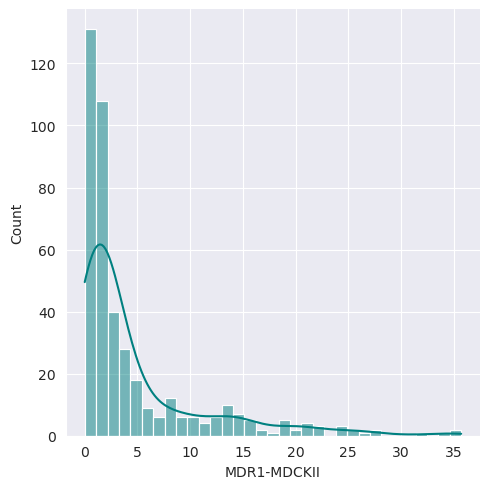

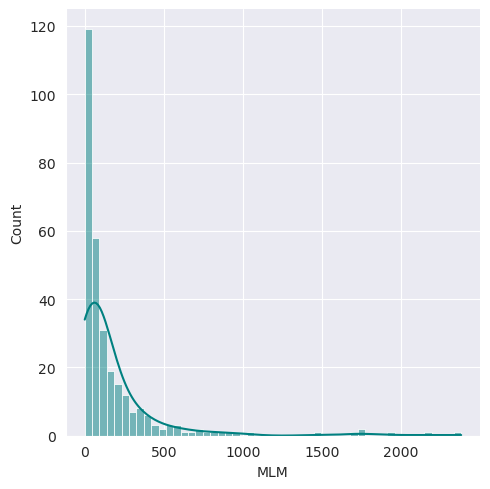

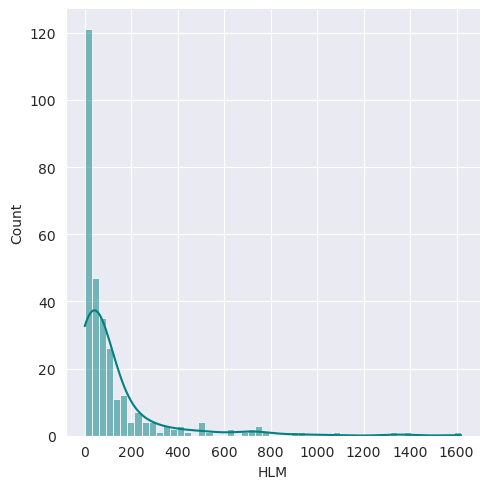

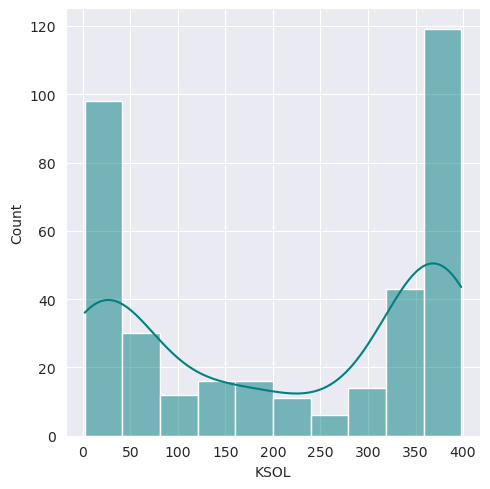

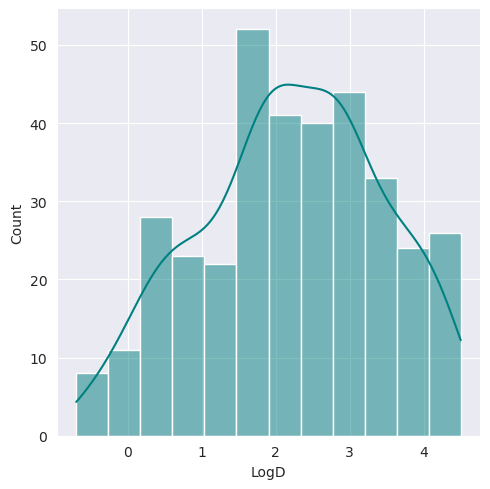

In [5]:
# draw distribution for each target
for tgt in train.target_cols:
    y = train.y[tgt]
    mask = ~np.isnan(y)
    data = train.y[tgt][mask]
    sns.displot(data=pd.DataFrame({tgt: data}),
            x=tgt, kde=True, color='teal')
plt.show()

In [6]:
# get mols from smiles
smiles_train = [smiles[0] for smiles in train]
mols_train = [Chem.MolFromSmiles(smiles_train[i]) for i in range(len(smiles_train))]


smiles_test = test
mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]

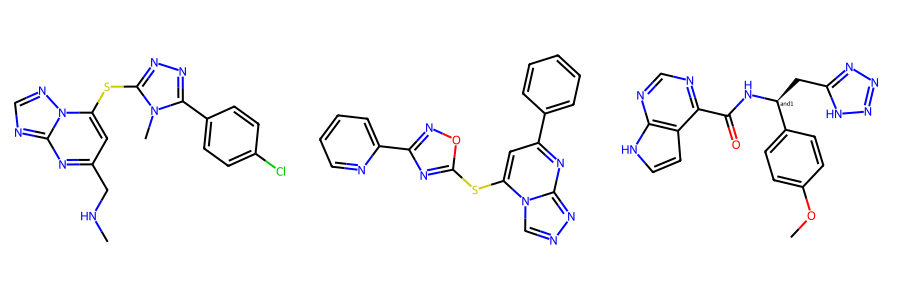

In [7]:
# draw some molecules for each target for each category (min, avg, max)
# Draw.MolsToGridImage(mols_test, molsPerRow=3, subImgSize=(300, 300))

#for tgt in train.target_cols: # why doesn't it print those, if I loop it :(
tgt = "MLM" #['MLM', 'HLM', 'MDR1-MDCKII', 'LogD', 'KSOL']
y = train.y[tgt]
mask = ~np.isnan(y)
min = np.min(y[mask])

min_indices = np.where(y == min)[0]
mols = [mols_train[i] for i in min_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

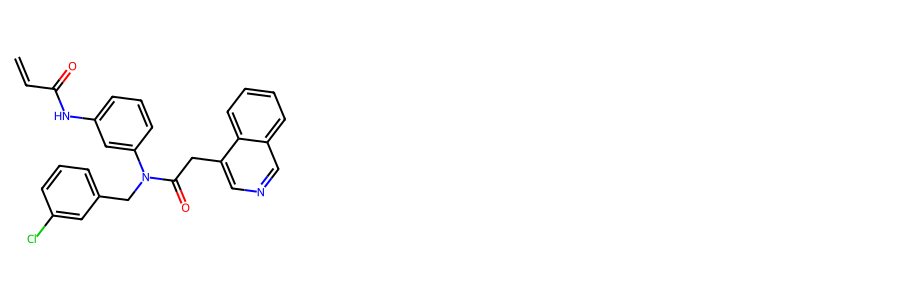

In [8]:
max = np.max(y[mask])

max_indices = np.where(y == max)[0]
mols = [mols_train[i] for i in max_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

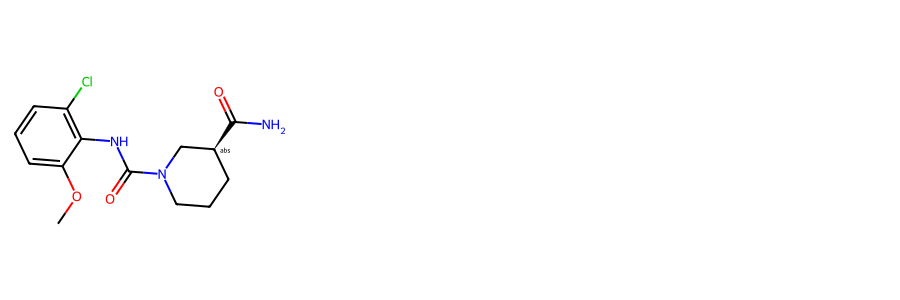

In [9]:
avg = np.average(y[mask])

avg_indices = [0] # todo: find avg indices
mols = [mols_train[i] for i in avg_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

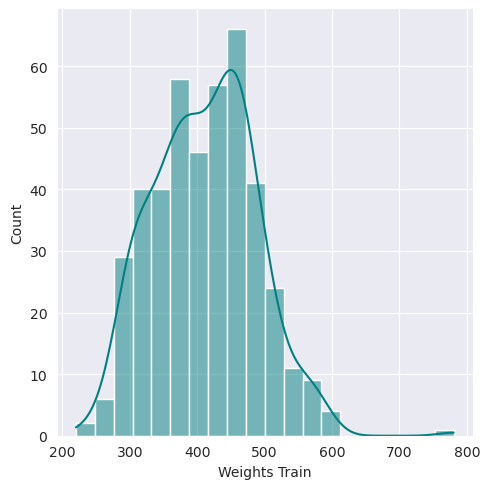

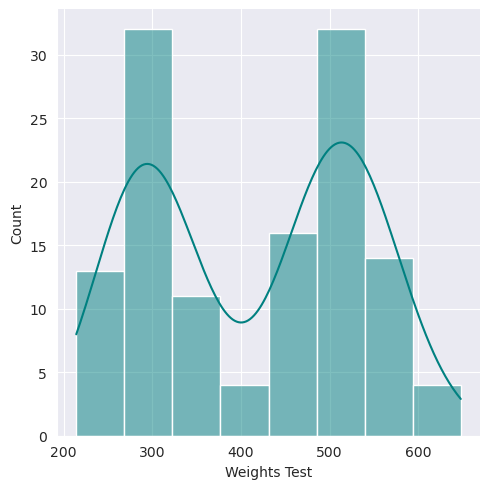

In [10]:
# distribution of molecular weight
# train

weights = [ExactMolWt(mol) for mol in mols_train]
sns.displot(data=pd.DataFrame({"Weights Train": weights}),
            x="Weights Train", kde=True, color='teal')
plt.show()

#test

weights = [ExactMolWt(mol) for mol in mols_test]
sns.displot(data=pd.DataFrame({"Weights Test": weights}),
            x="Weights Test", kde=True, color='teal')
plt.show()


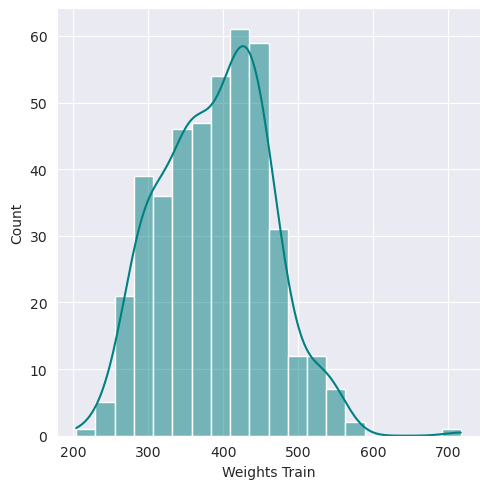

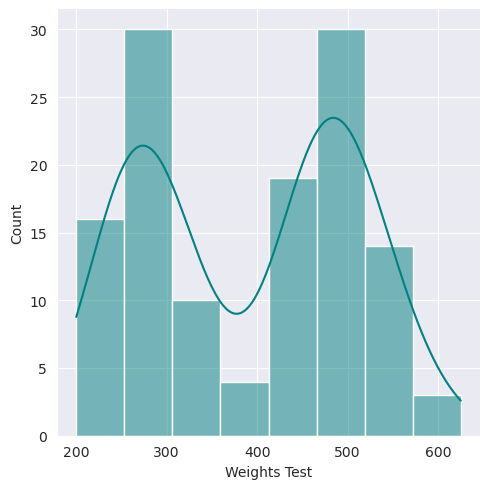

In [11]:
# distribution of molecular weight
# train

weights = [HeavyAtomMolWt(mol) for mol in mols_train]
sns.displot(data=pd.DataFrame({"Weights Train": weights}),
            x="Weights Train", kde=True, color='teal')
plt.show()

#test

weights = [HeavyAtomMolWt(mol) for mol in mols_test]
sns.displot(data=pd.DataFrame({"Weights Test": weights}),
            x="Weights Test", kde=True, color='teal')
plt.show()


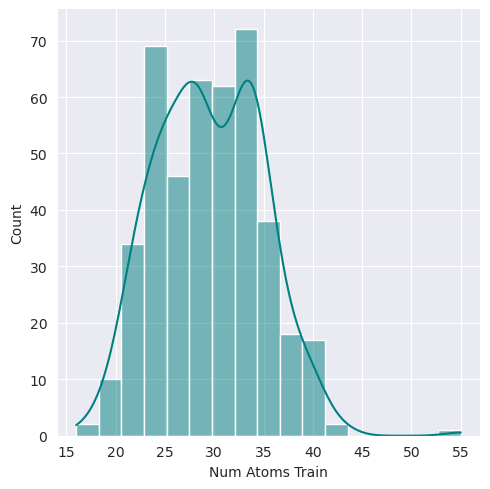

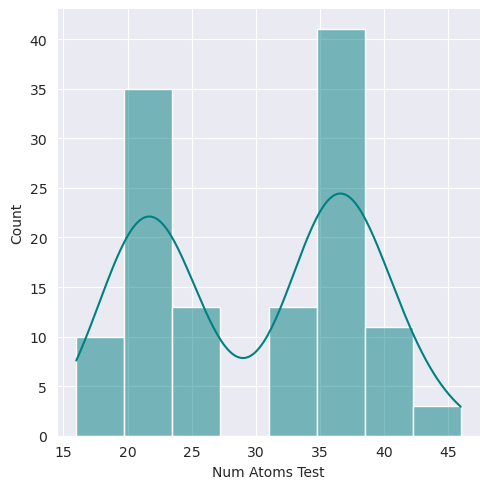

In [12]:
# distribution of number of atoms
# train

weights = [mol.GetNumAtoms() for mol in mols_train]
sns.displot(data=pd.DataFrame({"Num Atoms Train": weights}),
            x="Num Atoms Train", kde=True, color='teal')
plt.show()

#test

weights = [mol.GetNumAtoms() for mol in mols_test]
sns.displot(data=pd.DataFrame({"Num Atoms Test": weights}),
            x="Num Atoms Test", kde=True, color='teal')
plt.show()


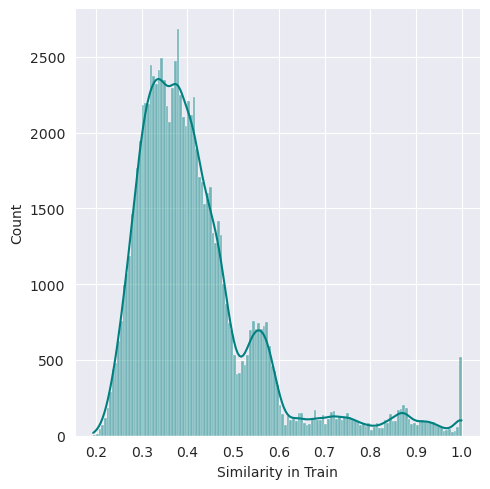

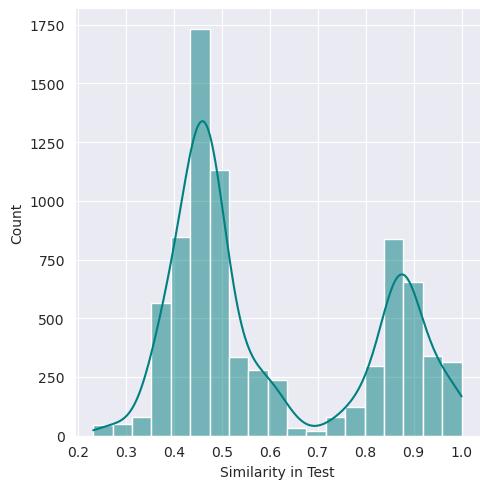

In [13]:
# distribution of similarity in train/test
# train
fps_train = [FingerprintMols.FingerprintMol(x) for x in mols_train]
sim = []

for i in range(len(fps_train)-1):
    for j in range(i, len(fps_train)):
        sim.append(DataStructs.TanimotoSimilarity(fps_train[i], fps_train[j]))

sns.displot(data=pd.DataFrame({"Similarity in Train": sim}),
            x="Similarity in Train", kde=True, color='teal')
plt.show()

#test
fps_test = [FingerprintMols.FingerprintMol(x) for x in mols_test]
sim = []

for i in range(len(fps_test)-1):
    for j in range(i, len(fps_test)):
        sim.append(DataStructs.TanimotoSimilarity(fps_test[i], fps_test[j]))


sns.displot(data=pd.DataFrame({"Similarity in Test": sim}),
            x="Similarity in Test", kde=True, color='teal')
plt.show()


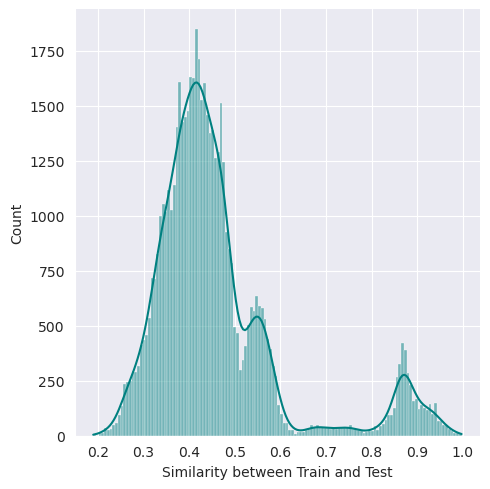

In [16]:
# distribution of similarity between train and test
sim = []
for i in range(len(fps_train)):
    for j in range(len(fps_test)):
        sim.append(DataStructs.TanimotoSimilarity(fps_train[i], fps_test[j]))

sns.displot(data=pd.DataFrame({"Similarity between Train and Test": sim}),
            x="Similarity between Train and Test", kde=True, color='teal')



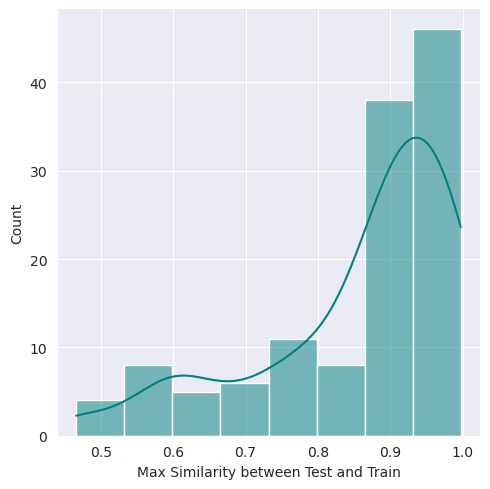

In [17]:
# distribution of max similarity between train and test
sim = []
for i in range(len(fps_test)):
    max = 0
    for j in range(len(fps_train)):
        simi = DataStructs.TanimotoSimilarity(fps_test[i], fps_train[j])
        if simi > max:
            max = simi
    sim.append(max)

sns.displot(data=pd.DataFrame({"Max Similarity between Test and Train": sim}),
            x="Max Similarity between Test and Train", kde=True, color='teal')


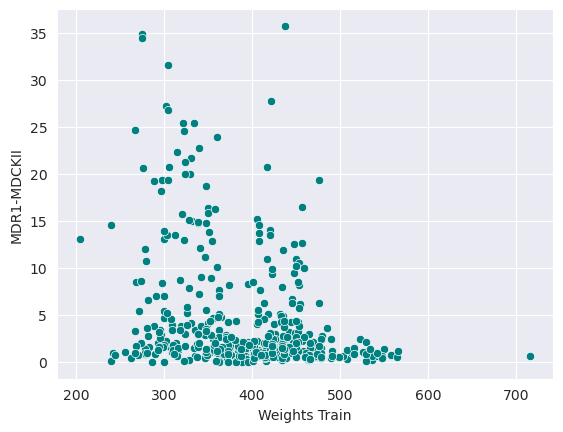

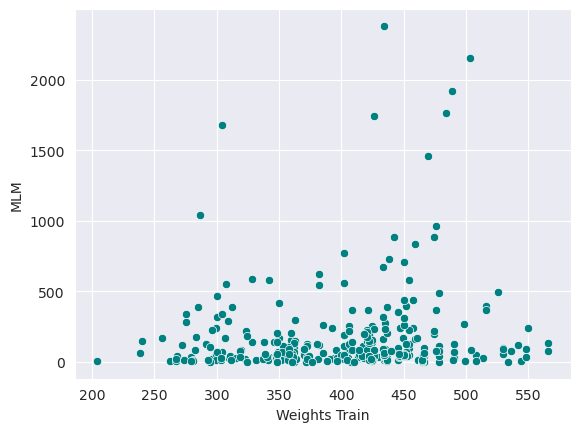

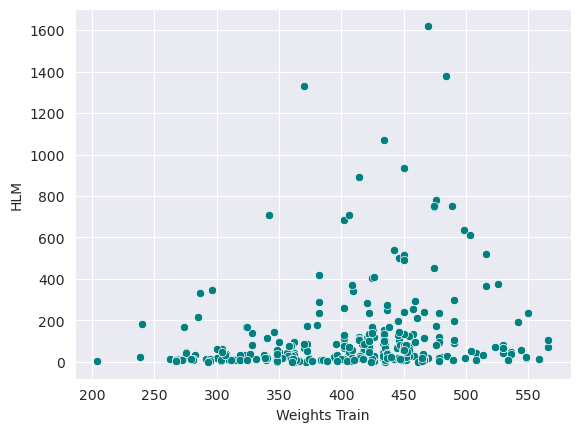

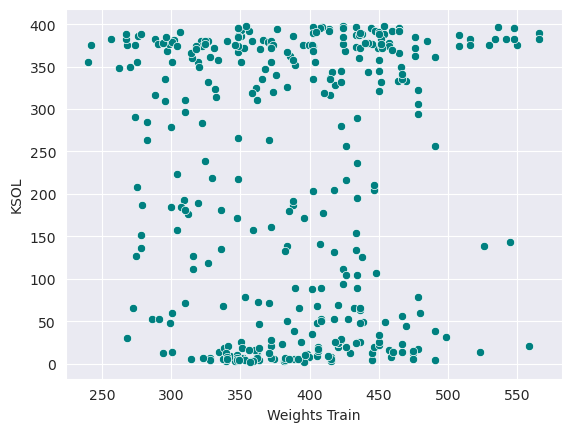

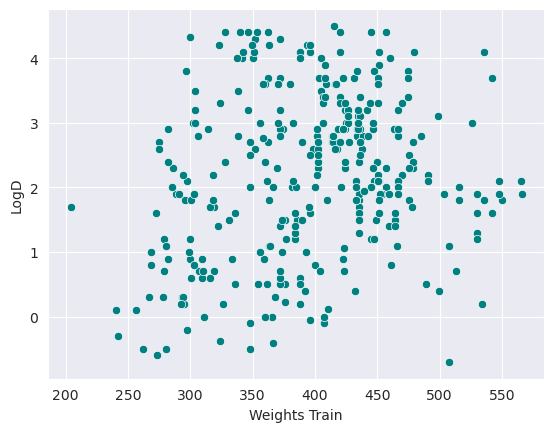

In [18]:
# scatter tgt vs mol weight
for tgt in train.target_cols:
    weights = [HeavyAtomMolWt(mol) for mol in mols_train]
    sns.scatterplot(data=pd.DataFrame({"Weights Train": weights, tgt:train.y[tgt]}),
            x="Weights Train",y=tgt, color='teal')
    plt.show()


In [19]:
print(train[0][1])
print(train[1][1])
print(train[2][1])

{'MDR1-MDCKII': 2.0, 'MLM': nan, 'HLM': nan, 'KSOL': nan, 'LogD': 0.3}
{'MDR1-MDCKII': 0.2, 'MLM': nan, 'HLM': nan, 'KSOL': 333.0, 'LogD': 2.9}
{'MDR1-MDCKII': 0.5, 'MLM': nan, 'HLM': nan, 'KSOL': nan, 'LogD': 0.4}


In [20]:
# mol sizes

# train
smiles = [smiles[0] for smiles in train]

mols = [Chem.MolFromSmiles(smiles[i]) for i in range(len(smiles))]
mol_sizes = [mol.GetNumAtoms() for mol in mols]
# mol weight

# test
smiles_test = [smiles[0] for smiles in train]

mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]
mol_sizes_test = [mol.GetNumAtoms() for mol in mols_test]


# use atom weight
# print(mol_sizes_test)

## Create ADMET CSV Dataset

In [5]:
train_data = {key: [] for key in ["smiles", "MLM", "HLM", "KSOL", "LogD", "MDR1-MDCKII"]}
test_data = {"smiles": list(test)}

for entry in train:
    train_data["smiles"].append(entry[0])
    for key in train_data.keys():
        if key != "smiles":
            train_data[key].append(entry[1][key])


In [6]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.to_csv("../data/polaris/admet/train_polaris.csv", index=False)
test_df.to_csv("../data/polaris/admet/test_polaris.csv", index=False)
